In [165]:
# Microsoft Turkey Summer Internship Program Projecy by Defne Meric Erdogan

In [166]:
# Importing libraries for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import optuna
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import time

In [98]:
# Importing the dataset
stocks = pd.read_csv('MSFT.csv')

# Data Analysis

In [99]:
print(stocks.head())

         Date      Open      High       Low     Close  Adj Close      Volume
0  1986-03-13  0.088542  0.101563  0.088542  0.097222   0.061434  1031788800
1  1986-03-14  0.097222  0.102431  0.097222  0.100694   0.063628   308160000
2  1986-03-17  0.100694  0.103299  0.100694  0.102431   0.064725   133171200
3  1986-03-18  0.102431  0.103299  0.098958  0.099826   0.063079    67766400
4  1986-03-19  0.099826  0.100694  0.097222  0.098090   0.061982    47894400


In [100]:
print(stocks.describe())

              Open         High          Low        Close    Adj Close  \
count  9083.000000  9083.000000  9083.000000  9083.000000  9083.000000   
mean     41.324936    41.760887    40.878488    41.335628    36.256120   
std      59.696905    60.272218    59.081728    59.714567    59.981436   
min       0.088542     0.092014     0.088542     0.090278     0.057046   
25%       4.050781     4.102051     4.027344     4.075195     2.575089   
50%      26.820000    27.100000    26.520000    26.840000    18.948530   
75%      40.034999    40.443751    39.500000    39.937500    29.244812   
max     344.619995   349.670013   342.200012   343.109985   342.402008   

             Volume  
count  9.083000e+03  
mean   5.875055e+07  
std    3.845200e+07  
min    2.304000e+06  
25%    3.461230e+07  
50%    5.203200e+07  
75%    7.265400e+07  
max    1.031789e+09  


In [101]:
print(stocks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9083 non-null   object 
 1   Open       9083 non-null   float64
 2   High       9083 non-null   float64
 3   Low        9083 non-null   float64
 4   Close      9083 non-null   float64
 5   Adj Close  9083 non-null   float64
 6   Volume     9083 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 496.9+ KB
None


In [102]:
print(stocks.isnull().sum()) # to check if there are any missing values we need to handle
# There are no missing values in the dataset

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## Visualizing

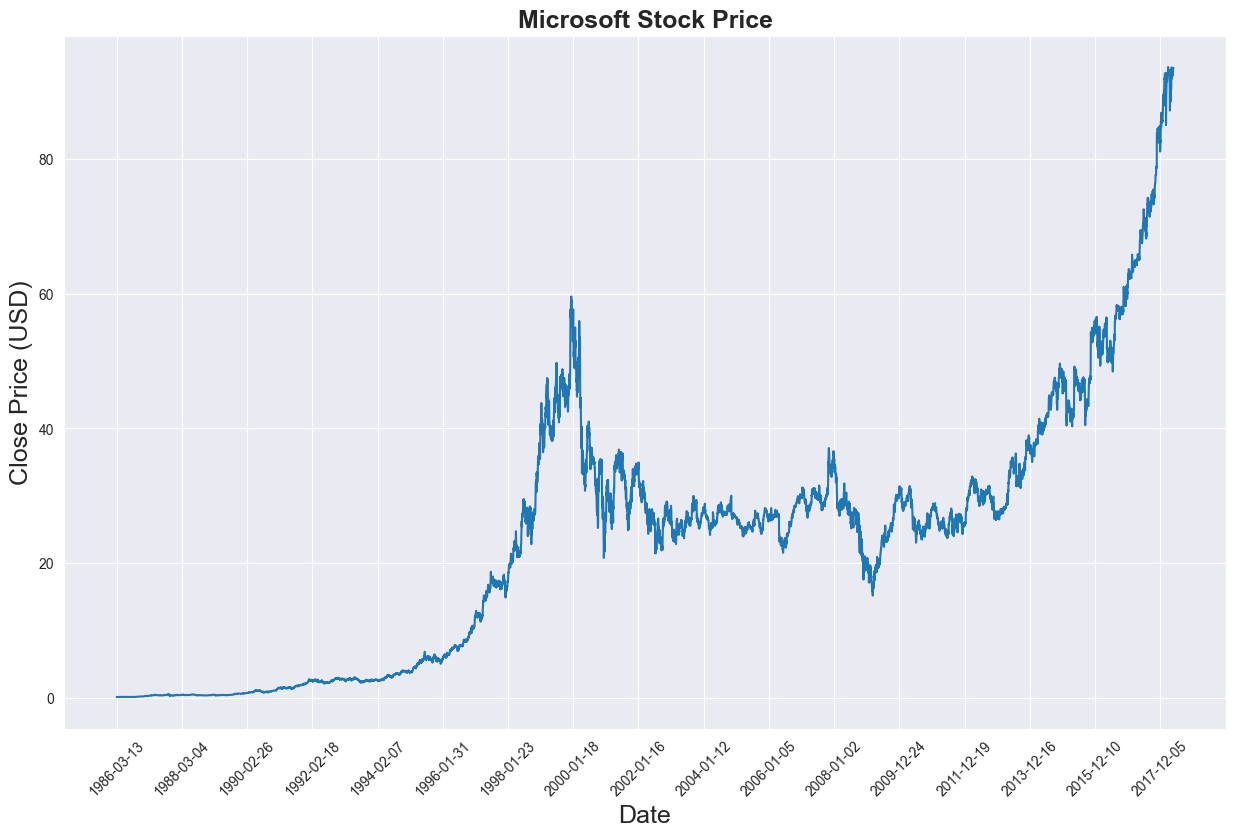

In [158]:
# We see the Close Price of the stock change with the time 
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(stocks['Close'])
plt.xticks(range(0,stocks.shape[0],500),stocks['Date'].loc[::500],rotation=45)
plt.title("Microsoft Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

## Handling Outliers

In [104]:
# Removes values that fall outside 1.5×IQR range:

Q1 = stocks['Close'].quantile(0.25)
Q3 = stocks['Close'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

stocks = stocks[(stocks['Close'] >= lower_bound) & (stocks['Close'] <= upper_bound)]


In [105]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8076 entries, 0 to 8101
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8076 non-null   object 
 1   Open       8076 non-null   float64
 2   High       8076 non-null   float64
 3   Low        8076 non-null   float64
 4   Close      8076 non-null   float64
 5   Adj Close  8076 non-null   float64
 6   Volume     8076 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 504.8+ KB


## Normalizing Data

In [ ]:

price = stocks[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8076 entries, 0 to 8101
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8076 non-null   float64
dtypes: float64(1)
memory usage: 126.2 KB


In [159]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price = price.copy()
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [108]:
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


# Preparation for Model

In [109]:
# Using sliding window method 
# This creates training sampels by taking a sequence of past values and using them to predict the next values.
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 30
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [ ]:
# Transforming the data into tensors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Adding random seed for reproducibility
# 42 as its the Answer to the Ultimate Question of Life :D
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor).to(device)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor).to(device)


Using device: cpu


TypeError: expected np.ndarray (got Tensor)

# LSTM MODEL

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.linear(out[:, -1, :]) 
        return out

## Finding Best Parameters with HyperParameter Optimization

In [112]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [117]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5, patience=10):
    early_stopping = EarlyStopping(patience=patience)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                output = model(x_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if early_stopping(val_loss):
            print(f"Early stopping at epoch {epoch}")
            break
    return val_loss


def objective(trial):
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Model
    model = LSTM(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Data loaders
    dataset = TensorDataset(x_train, y_train_lstm)
    val_dataset = TensorDataset(x_test, y_test_lstm)

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    val_loss = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5, patience=5)
    return val_loss


In [118]:
study = optuna.create_study(direction="minimize")
#study.optimize(objective, n_trials=1000, show_progress_bar=True, n_jobs=3)
study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial
for key, value in trial.params.items():
    print(f"{key}: {value}")


[I 2025-07-17 14:39:17,365] A new study created in memory with name: no-name-564ce785-7d62-4399-b1d7-936e2fd3d29a
[I 2025-07-17 14:39:44,588] Trial 0 finished with value: 0.003420794911037844 and parameters: {'hidden_dim': 201, 'num_layers': 3, 'lr': 0.000966682061739338, 'batch_size': 128}. Best is trial 0 with value: 0.003420794911037844.
[I 2025-07-17 14:40:12,436] Trial 1 finished with value: 0.0008464322132104094 and parameters: {'hidden_dim': 206, 'num_layers': 2, 'lr': 0.004007809372758883, 'batch_size': 32}. Best is trial 1 with value: 0.0008464322132104094.
[I 2025-07-17 14:41:05,423] Trial 2 finished with value: 0.005124234403232478 and parameters: {'hidden_dim': 255, 'num_layers': 3, 'lr': 0.0001231536633826369, 'batch_size': 32}. Best is trial 1 with value: 0.0008464322132104094.
[I 2025-07-17 14:41:33,228] Trial 3 finished with value: 0.07384948182600336 and parameters: {'hidden_dim': 206, 'num_layers': 3, 'lr': 0.007965618818888055, 'batch_size': 128}. Best is trial 1 wit

Best trial:
hidden_dim: 206
num_layers: 2
lr: 0.004007809372758883
batch_size: 32


In [119]:
best_params = study.best_trial.params
print(best_params)

{'hidden_dim': 206, 'num_layers': 2, 'lr': 0.004007809372758883, 'batch_size': 32}


In [140]:
# Set the parameters for the LSTM model with the best parameters
input_dim = 1
hidden_dim = study.best_params['hidden_dim']
num_layers = study.best_params['num_layers']
output_dim = 1
num_epochs = 50
learning_rate = study.best_params['lr']
batch_size = study.best_params['batch_size']

In [136]:
# Initialize the model, loss function, and optimizer
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Create TensorDatasets
train_dataset = TensorDataset(x_train, y_train_lstm)
val_dataset = TensorDataset(x_test, y_test_lstm)

# Create DataLoaders with batch_size from Optuna
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## Train the Model

In [ ]:
def train_model_optuna(model, loss_fn, optimizer, train_loader, val_loader, num_epochs=num_epochs, patience=10):
    early_stopping = EarlyStopping(patience=patience)
    best_val_loss = float('inf')
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for x_batch, y_batch in train_loader:
            output = model(x_batch)
            loss = loss_fn(output, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                output = model(x_batch)
                val_loss = loss_fn(output, y_batch)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1} / {num_epochs}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        if early_stopping(avg_val_loss):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds")
    return avg_val_loss

train_model_optuna(model, loss_fn, optimizer, train_loader, val_loader, num_epochs)


Epoch 1: Train Loss = 0.000197, Val Loss = 0.000999
Epoch 2: Train Loss = 0.000162, Val Loss = 0.000830
Epoch 3: Train Loss = 0.000166, Val Loss = 0.000266
Epoch 4: Train Loss = 0.000171, Val Loss = 0.000297
Epoch 5: Train Loss = 0.000170, Val Loss = 0.000529
Epoch 6: Train Loss = 0.000167, Val Loss = 0.000571
Epoch 7: Train Loss = 0.000203, Val Loss = 0.000302
Epoch 8: Train Loss = 0.000186, Val Loss = 0.000601
Epoch 9: Train Loss = 0.000171, Val Loss = 0.000386
Epoch 10: Train Loss = 0.000195, Val Loss = 0.000271
Epoch 11: Train Loss = 0.000186, Val Loss = 0.001260
Epoch 12: Train Loss = 0.000185, Val Loss = 0.000968
Epoch 13: Train Loss = 0.000162, Val Loss = 0.000671
Epoch 14: Train Loss = 0.000169, Val Loss = 0.000959
Epoch 15: Train Loss = 0.000195, Val Loss = 0.000699
Epoch 16: Train Loss = 0.000186, Val Loss = 0.005579
Epoch 17: Train Loss = 0.000167, Val Loss = 0.000500
Epoch 18: Train Loss = 0.000304, Val Loss = 0.000659
Epoch 19: Train Loss = 0.000171, Val Loss = 0.000550
Ep

0.0009060251571402963

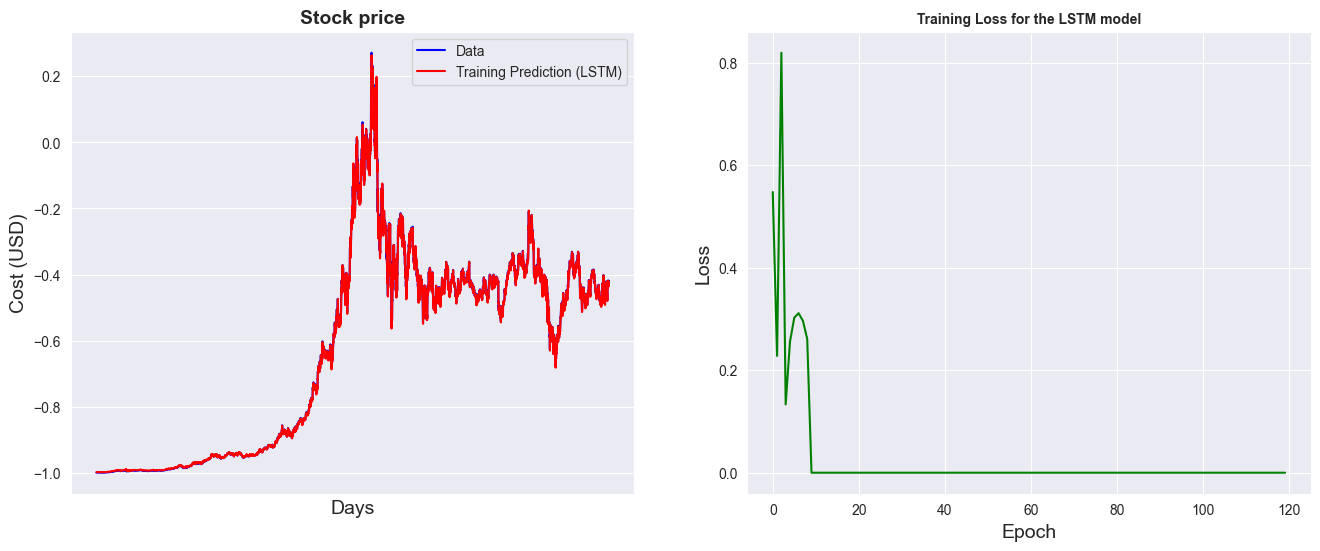

In [162]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
original = pd.DataFrame(y_train_lstm.cpu().numpy())
predict = pd.DataFrame(model(x_train).detach().cpu().numpy())
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticks([])


#Visualizing the training loss
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='green')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss for the LSTM model", size = 10, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

# The training prediction for the LSTM model is really good.

## Evaluate the Model

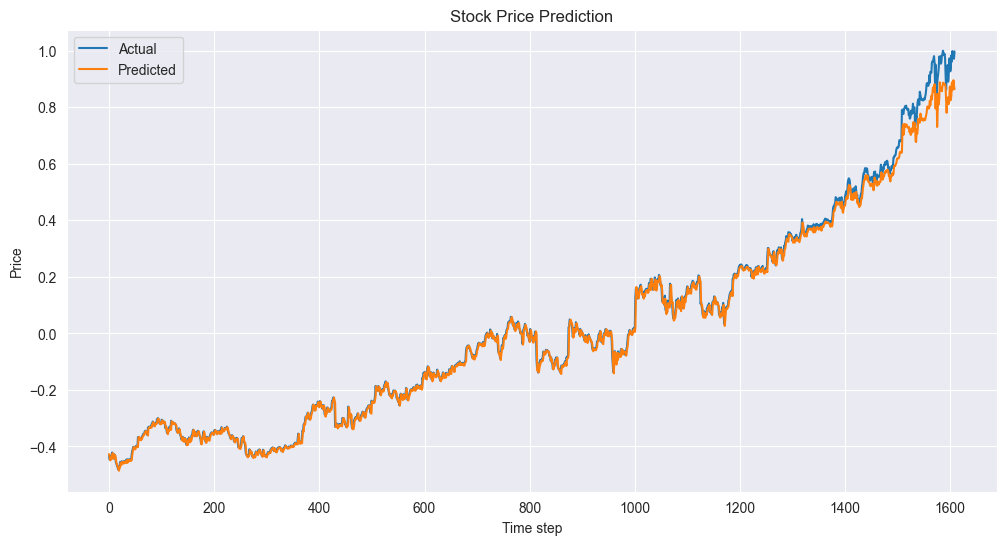

In [169]:
def evaluate_model(model, x_test, y_test, scaler):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test).to(device)
        true_values = y_test.cpu().numpy()

    # Inverse scale
    predictions_rescaled = scaler.inverse_transform(predictions.cpu().numpy())

    true_rescaled = scaler.inverse_transform(true_values)

    return predictions_rescaled, true_rescaled

predicted, actual = evaluate_model(model, x_test, y_test_lstm, scaler)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted")
plt.title("Stock Price Prediction")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.legend()
plt.savefig('images/lstm_prediction.png')
plt.show()



In [163]:
torch.save(model.state_dict(), "best_lstm_model.pth")